In [2]:
import pandas as pd
import numpy as np
%env CUDA_VISIBLE_DEVICES=0
%env LIBRARY_PATH=/usr/local/cuda/lib64
import sys
import os
import tables
from tqdm import *
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D


env: CUDA_VISIBLE_DEVICES=0
env: LIBRARY_PATH=/usr/local/cuda/lib64


In [3]:
train_file = "train_3-4.hdf5"
test_file = "test_3-4.hdf5"
submission_file = 'submission_1-2.hdf5'

CROP_SIZE=19


event_index = 15
#crop = f.root.data[event_index]
#data_labels = f.root.label[event_index]


def make_crops(images, size=19):
    crops = np.zeros(((images > 0).sum() , 1, size, size, size))
    half_size = size // 2
    calc = 0
    for image in images:
        image = np.pad(image, ((0,0), (half_size, half_size), (half_size, half_size), (half_size, half_size)),
                       'constant', constant_values=0)
        
        non_zero_pixels = np.array(np.where(image[0] > 0)).T    
        for row in non_zero_pixels:
            crops[calc] = image[0, row[0] - half_size : row[0] + half_size + 1,
                                   row[1] - half_size : row[1] + half_size + 1,
                                   row[2] - half_size : row[2] + half_size + 1]
            calc += 1
            
    
    return crops

def read_events(start_index=0, end_index=100, energy_scale=255):
    X_train, y_train = [], []
    for event_index in trange(start_index, end_index):
        data_hits = np.expand_dims(np.array(f.root.data[event_index : event_index + 1]), axis=1)
        data_hits = data_hits * energy_scale / data_hits.max(axis=(1,2,3,4), keepdims=True)
        data_labels = np.expand_dims(np.array(f.root.label[event_index : event_index + 1]), axis=1)
        X_train.append(make_crops(data_hits, size=CROP_SIZE))
        y_train.append(data_labels[data_hits > 0] - 1)
#         else:
#             X_train = np.vstack((X_train, make_crops(data_hits, size=CROP_SIZE)))
#             y_train = np.hstack((y_train, data_labels[data_hits > 0] - 1))
    return np.concatenate(X_train), np.concatenate(y_train)

In [4]:
f = tables.open_file(test_file)

In [5]:
len(f.root.data)

10000

In [6]:
def hdf5_to_numpy(box_ind, file='test_1-2.hdf5', n=100, num_classes=2, test=False, ohe=False):
    """
    Converts .hdf5-data to numpy array.
    :param file: string
    :param n: int or np.inf
    :param num_classes: int, either 2 or 3
    :return:
    X: np.array[N, 4] -- x, y, z coordinates, energy normalized to [0, 1] range
    Y: np.array[N] -- label
    M: np.array[N, 3] -- original positions of each entry
    N: int -- total number of events
    """
    #f = tables.open_file(file)
    X = list()
    Y = list()
    M = list()
    N = min(len(f.root.data), n)
    boxes = np
    #print(len(f.root.data))
    i = box_ind
    data = f.root.data[i]
    mask = data > 0
    x, y, z = np.where(mask)
    v = data[np.where(mask)]

    X.append(np.stack([x / X_MAX, 
                       y / Y_MAX,
                       z / Z_MAX,
                       v / E_SCALE]).T)
    if not test:
        label = f.root.label[i]
        if ohe:
            Y.append(
                ohe_transform(label[np.where(mask)], num_classes=num_classes)
            )
        else:
            Y.append(label[np.where(mask)])
    else:
        Y.append(np.zeros((len(np.where(mask)[0]), num_classes)))
    M.append(np.array(np.where(mask)).T)
    #f.close()
    return np.hstack((X[0], M[0])), Y[0] if not test else np.hstack((X[0], M[0]))

def ohe_transform(y, num_classes=2):
    if num_classes == 2:
        y_ohe = np.zeros((len(y), 2))
        y_ohe[:, 0] = (y == 1.)
        y_ohe[:, 1] = (y == 2.)
    elif num_classes == 4:
        y_ohe = np.zeros((len(y), 4))
        y_ohe[:, 0] = (y == 0.)
        y_ohe[:, 1] = (y == 1.)
        y_ohe[:, 2] = (y == 2.)
        y_ohe[:, 3] = (y == 3.)
    else:
        raise BaseException
    return y_ohe

In [7]:
f.root.data

/data (EArray(10000, 192, 192, 192), shuffle, zlib(5)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 7, 192, 192)

In [ ]:
X_MAX, Y_MAX, Z_MAX = 191., 191., 191.
E_SCALE = 50


full_train = []
full_label = []

for cur_ind in trange(10000):
    X_train, y_train = hdf5_to_numpy(cur_ind)
    full_train.append(X_train)
    full_label.append(y_train)

 96%|█████████▌| 9584/10000 [43:07<01:52,  3.70it/s]

In [89]:
X_MAX, Y_MAX, Z_MAX = 191., 191., 191.
E_SCALE = 50

full_test = []

for cur_ind in trange(10000):
    X_test_tmp = hdf5_to_numpy(cur_ind, test=True)
    full_test.append(X_test_tmp)

100%|██████████| 10000/10000 [31:49<00:00,  5.24it/s]


In [90]:
import pickle

with open('test.pickle', 'wb') as tr:
    pickle.dump(full_test, tr)

In [80]:
import pickle

with open('test.pickle', 'rb') as tr:
    full_test = pickle.load(tr)

In [81]:
full_test_ind = []

for cur_ind, one_ind in enumerate(full_test):
    xes = one_ind[0]
    if len(xes) == 0:
        print(cur_ind)
    full_test_ind += [cur_ind] * len(xes)

full_test_ind = np.array(full_test_ind)

2027


In [82]:
full_test = np.concatenate(np.array(full_test)[:, 0])

In [ ]:
import pickle

with open('train.pickle', 'wb') as tr:
    pickle.dump([full_train, full_label], tr)

In [8]:
import pickle

with open('train.pickle', 'rb') as tr:
    train = pickle.load(tr)

In [9]:
full_train_ind = []

for cur_ind, one_ind in enumerate(train[0]):
    xes = one_ind
    full_train_ind += [cur_ind] * len(xes)

full_train_ind = np.array(full_train_ind)

In [10]:
full_train = np.concatenate(train[0])
full_train_label = np.concatenate(train[1])

#full_train = np.hstack((full_train, full_train_ind[::, np.newaxis]))

In [76]:
X_train = full_train[full_train_ind < 8000]
y_train = full_train_label[full_train_ind < 8000]

X_val = full_train[full_train_ind > 8000]
y_val = full_train_label[full_train_ind > 8000]

In [155]:
X_train = X_train[::, 3:]
X_val = X_val[::, 3:]

In [11]:
def rlencode(x, dropna=False):
    where = np.flatnonzero
    x = np.asarray(x)
    n = len(x)
    if n == 0:
        return (np.array([], dtype=int), 
                np.array([], dtype=int), 
                np.array([], dtype=x.dtype))

    starts = np.r_[0, where(~np.isclose(x[1:], x[:-1], equal_nan=True)) + 1]
    lengths = np.diff(np.r_[starts, n])
    values = x[starts]
    
    if dropna:
        mask = ~np.isnan(values)
        starts, lengths, values = starts[mask], lengths[mask], values[mask]
    
    return starts, lengths, values

In [12]:
box_start_pos, box_len, _ = rlencode(full_train_ind)

In [83]:
box_start_pos_test, box_len_test, _ = rlencode(full_test_ind)

In [172]:
full_train.shape

(27993775, 7)

In [173]:
box_len, box_start_pos

(array([       0,     2483,     5553, ..., 27981983, 27986601, 27991219]),
 array([2483, 3070, 1730, ..., 4618, 4618, 2556]))

In [175]:
full_train[tmp_box_start_pos:tmp_box_start_pos + tmp_box_len]

array([], shape=(0, 7), dtype=float64)

In [176]:
tmp_box_start_pos

2483

In [253]:
full_train.shape, full_train_label.shape

((27993775, 7), (27993775,))

In [37]:
tmp = full_train[:300][::, 3:]

In [38]:
tmp[::, 1]

array([ 72.,  73.,  73.,  73.,  73.,  73.,  74.,  75.,  76.,  76.,  76.,
        76.,  76.,  77.,  81.,  81.,  82.,  82.,  82.,  82.,  82.,  83.,
        84.,  85.,  85.,  85.,  85.,  85.,  85.,  86.,  87.,  87.,  88.,
        88.,  88.,  88.,  88.,  88.,  88.,  88.,  88.,  88.,  89.,  89.,
        89.,  90.,  90.,  91.,  91.,  99.,  99., 100., 100., 100., 100.,
       100., 101., 101., 103., 103., 104., 104., 104., 104., 104., 105.,
       106., 106., 107., 107., 107., 107., 107., 107., 108., 108., 108.,
       108., 108., 108., 109., 109., 109., 110., 110., 110., 110., 111.,
       111., 111., 111., 111., 111., 111., 111., 111., 111., 112., 112.,
       112., 113., 113., 113., 114., 114., 114., 114., 114., 115., 115.,
       116., 117., 117., 117., 117., 117., 118., 118., 119., 119., 119.,
       119., 119., 119., 119., 119., 119., 120., 120., 120., 120., 120.,
       120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 121.,
       121., 121., 121., 121., 121., 121., 121., 12

In [66]:
def get_pdf(data, bins=75):
    probs, bins = np.histogram(data, bins=bins, density=True)
    indexes = np.digitize(data, bins=bins, right=True)
    return probs[indexes - 1]

In [84]:
from sklearn.neighbors import KDTree

extended_test = []
extended_boxes = []

k = 6

for cur_ind, tmp_box_start_pos, tmp_box_len in tqdm(zip(range(9999), box_start_pos_test, box_len_test)):
    cur_data = full_test[tmp_box_start_pos:tmp_box_start_pos + tmp_box_len][::, 3:]
    if len(cur_data) > k:
        extended_boxes += [_[cur_ind]] * len(cur_data)
        tree = KDTree(cur_data)
        neigh = tree.query(cur_data, k=k)[1]
        tmp_data = cur_data[neigh].reshape((len(cur_data), k * 4))
        x = tmp_data[:, 1::4]
        y = tmp_data[:, 2::4]
        z = tmp_data[:, 3::4]
        en = tmp_data[:, 0::4]
        min_x = cur_data[x[::, 0].argmin()]
        min_y = cur_data[y[::, 0].argmin()]
        min_z = cur_data[z[::, 0].argmin()]
        cur_data_coords = cur_data[::, 1:]

        min_x_coords = min_x[1:]
        min_y_coords = min_y[1:]
        min_z_coords = min_z[1:]


        min_x_energy = min_x[0]
        min_y_energy = min_y[0]
        min_z_energy = min_z[0]

        cur_data_energy = cur_data[::, 0]

        dif_x_eng = cur_data_energy - min_x_energy
        dif_y_eng = cur_data_energy - min_y_energy
        dif_z_eng = cur_data_energy - min_z_energy



        x_dist = np.sum((cur_data_coords - min_x_coords) ** 2, axis=-1) ** 0.5
        y_dist = np.sum((cur_data_coords - min_y_coords) ** 2, axis=-1) ** 0.5
        z_dist = np.sum((cur_data_coords - min_z_coords) ** 2, axis=-1) ** 0.5
        
        x_probs = get_pdf(cur_data[::, 1])[::, np.newaxis]
        y_probs = get_pdf(cur_data[::, 2])[::, np.newaxis]
        z_probs = get_pdf(cur_data[::, 3])[::, np.newaxis]
        en_probs = get_pdf(cur_data[::, 0])[::, np.newaxis]

        features = (tmp_data,
                  x.mean(axis=-1)[::, np.newaxis],
                  y.mean(axis=-1)[::, np.newaxis],
                  z.mean(axis=-1)[::, np.newaxis],
                  x.ptp(axis=-1)[::, np.newaxis],
                  y.ptp(axis=-1)[::, np.newaxis],
                  z.ptp(axis=-1)[::, np.newaxis],
                  x.var(axis=-1)[::, np.newaxis],
                  y.var(axis=-1)[::, np.newaxis],
                  z.var(axis=-1)[::, np.newaxis],
                  en.mean(axis=-1)[::, np.newaxis],
                  en.std(axis=-1)[::, np.newaxis],
                  en.var(axis=-1)[::, np.newaxis],
                  en.ptp(axis=-1)[::, np.newaxis],
                    x_dist[::, np.newaxis],
                    y_dist[::, np.newaxis],
                    z_dist[::, np.newaxis],
                    dif_x_eng[::, np.newaxis],
                    dif_y_eng[::, np.newaxis],
                    dif_z_eng[::, np.newaxis],
                    x_probs,
                    y_probs,
                    z_probs,
                    en_probs
                )

        tmp_data = np.hstack(features)
        extended_test.append(tmp_data)

9999it [03:28, 47.98it/s]


In [68]:
from sklearn.neighbors import KDTree

extended_train = []
extended_labels = []

k = 6

for cur_ind, tmp_box_start_pos, tmp_box_len in tqdm(zip(range(9999), box_start_pos, box_len)):
    cur_data = full_train[tmp_box_start_pos:tmp_box_start_pos + tmp_box_len][::, 3:]
    if len(cur_data) > k:
        extended_labels.append(full_train_label[tmp_box_start_pos:tmp_box_start_pos + tmp_box_len])
        tree = KDTree(cur_data)
        neigh = tree.query(cur_data, k=k)[1]
        tmp_data = cur_data[neigh].reshape((len(cur_data), k * 4))
        x = tmp_data[:, 1::4]
        y = tmp_data[:, 2::4]
        z = tmp_data[:, 3::4]
        en = tmp_data[:, 0::4]
        min_x = cur_data[x[::, 0].argmin()]
        min_y = cur_data[y[::, 0].argmin()]
        min_z = cur_data[z[::, 0].argmin()]
        cur_data_coords = cur_data[::, 1:]

        min_x_coords = min_x[1:]
        min_y_coords = min_y[1:]
        min_z_coords = min_z[1:]


        min_x_energy = min_x[0]
        min_y_energy = min_y[0]
        min_z_energy = min_z[0]

        cur_data_energy = cur_data[::, 0]

        dif_x_eng = cur_data_energy - min_x_energy
        dif_y_eng = cur_data_energy - min_y_energy
        dif_z_eng = cur_data_energy - min_z_energy



        x_dist = np.sum((cur_data_coords - min_x_coords) ** 2, axis=-1) ** 0.5
        y_dist = np.sum((cur_data_coords - min_y_coords) ** 2, axis=-1) ** 0.5
        z_dist = np.sum((cur_data_coords - min_z_coords) ** 2, axis=-1) ** 0.5

        x_probs = get_pdf(cur_data[::, 1])[::, np.newaxis]
        y_probs = get_pdf(cur_data[::, 2])[::, np.newaxis]
        z_probs = get_pdf(cur_data[::, 3])[::, np.newaxis]
        en_probs = get_pdf(cur_data[::, 0])[::, np.newaxis]

        features = (tmp_data,
                  x.mean(axis=-1)[::, np.newaxis],
                  y.mean(axis=-1)[::, np.newaxis],
                  z.mean(axis=-1)[::, np.newaxis],
                  x.ptp(axis=-1)[::, np.newaxis],
                  y.ptp(axis=-1)[::, np.newaxis],
                  z.ptp(axis=-1)[::, np.newaxis],
                  x.var(axis=-1)[::, np.newaxis],
                  y.var(axis=-1)[::, np.newaxis],
                  z.var(axis=-1)[::, np.newaxis],
                  en.mean(axis=-1)[::, np.newaxis],
                  en.std(axis=-1)[::, np.newaxis],
                  en.var(axis=-1)[::, np.newaxis],
                  en.ptp(axis=-1)[::, np.newaxis],
                    x_dist[::, np.newaxis],
                    y_dist[::, np.newaxis],
                    z_dist[::, np.newaxis],
                    dif_x_eng[::, np.newaxis],
                    dif_y_eng[::, np.newaxis],
                    dif_z_eng[::, np.newaxis],
                    x_probs,
                    y_probs,
                    z_probs,
                    en_probs
                )

        tmp_data = np.hstack(features)
        extended_train.append(tmp_data)

9999it [03:49, 43.61it/s]


In [69]:
extended_train = np.concatenate(extended_train)
#extended_val = np.concatenate(extended_val)
extended_train_labels = np.concatenate(extended_labels)

In [86]:
extended_test = np.concatenate(extended_test)

In [87]:
extended_boxes = np.array(extended_boxes)

In [89]:
len(extended_boxes) == len(extended_test)

True

In [288]:
extended_test.shape

(27925412, 59)

In [191]:
y_train = full_train_label[full_train_ind < 8001]
y_val = full_train_label[full_train_ind > 8000]

In [166]:
X_train[tree.query(X_train[:10], k=5)[1]].shape

(10, 5, 4)

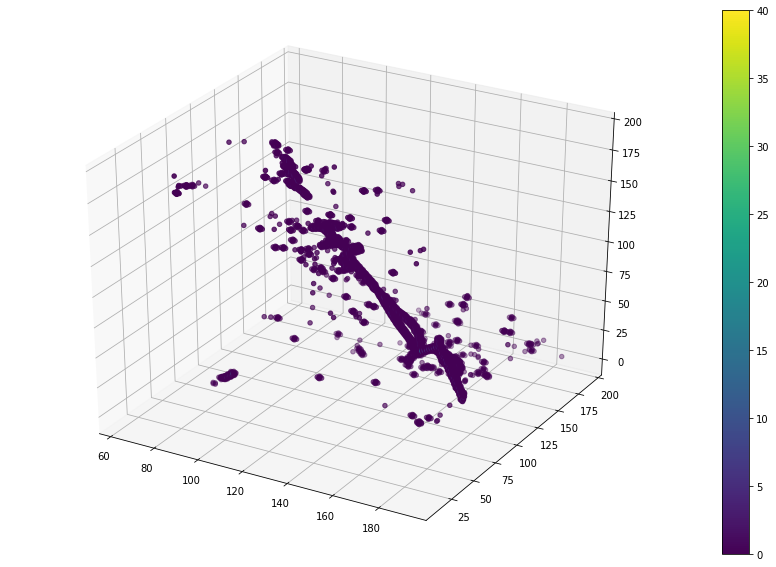

In [126]:
f=tables.open_file(train_file, 'r')
event_index = 599
crop = f.root.data[event_index]
data_labels = f.root.label[event_index]
#crop = X_train[0]
fig=plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111,projection='3d')
x,y,z = np.where(crop>0)
v=crop[crop>0]
cv = ax.scatter(x,y,z,c=v, marker='o', vmin=0,vmax=40)
plt.colorbar(cv)
plt.show()
f.close()

In [128]:
x_zeros, y_zeros, z_zeros = np.where(crop==0)

In [133]:
np.unique(data_labels[crop==0])

array([0.], dtype=float32)

In [ ]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
import plotly.graph_objs as go
init_notebook_mode(connected=True)

import numpy as np


trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color=data_labels[crop > 0],#'rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    ), showlegend=True
)


data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='simple-3d-scatter')

In [ ]:
data_labels.shape

In [ ]:
f=tables.open_file('test_1-2.hdf5', 'r')
energy_scale = 255
threshold = 0.5

test_size = f.root.data.shape[0]
f.close()

In [ ]:
f_submission.close()

In [74]:
TRAIN_SIZE = int(len(extended_train) * 0.995)

In [75]:
TRAIN_SIZE

27853806

In [255]:
extended_train_labels.shape

(27993775,)

In [76]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

model = LGBMClassifier(objective='multiclass', n_estimators=500)
model.fit(extended_train[:TRAIN_SIZE], extended_train_labels[:TRAIN_SIZE],
          eval_set=[(extended_train[TRAIN_SIZE:], extended_train_labels[TRAIN_SIZE:])])

[1]	valid_0's multi_logloss: 1.26383
[2]	valid_0's multi_logloss: 1.16349
[3]	valid_0's multi_logloss: 1.07927
[4]	valid_0's multi_logloss: 1.00743
[5]	valid_0's multi_logloss: 0.945473
[6]	valid_0's multi_logloss: 0.891244
[7]	valid_0's multi_logloss: 0.843389
[8]	valid_0's multi_logloss: 0.801165
[9]	valid_0's multi_logloss: 0.763973
[10]	valid_0's multi_logloss: 0.730503
[11]	valid_0's multi_logloss: 0.700482
[12]	valid_0's multi_logloss: 0.673866
[13]	valid_0's multi_logloss: 0.649336
[14]	valid_0's multi_logloss: 0.627626
[15]	valid_0's multi_logloss: 0.60795
[16]	valid_0's multi_logloss: 0.589991
[17]	valid_0's multi_logloss: 0.573749
[18]	valid_0's multi_logloss: 0.559082
[19]	valid_0's multi_logloss: 0.545034
[20]	valid_0's multi_logloss: 0.532885
[21]	valid_0's multi_logloss: 0.521186
[22]	valid_0's multi_logloss: 0.510704
[23]	valid_0's multi_logloss: 0.501032
[24]	valid_0's multi_logloss: 0.492575
[25]	valid_0's multi_logloss: 0.484367
[26]	valid_0's multi_logloss: 0.477151


[209]	valid_0's multi_logloss: 0.349175
[210]	valid_0's multi_logloss: 0.349179
[211]	valid_0's multi_logloss: 0.349073
[212]	valid_0's multi_logloss: 0.34897
[213]	valid_0's multi_logloss: 0.348928
[214]	valid_0's multi_logloss: 0.348885
[215]	valid_0's multi_logloss: 0.348809
[216]	valid_0's multi_logloss: 0.348736
[217]	valid_0's multi_logloss: 0.348628
[218]	valid_0's multi_logloss: 0.348591
[219]	valid_0's multi_logloss: 0.348537
[220]	valid_0's multi_logloss: 0.348469
[221]	valid_0's multi_logloss: 0.348368
[222]	valid_0's multi_logloss: 0.348325
[223]	valid_0's multi_logloss: 0.348301
[224]	valid_0's multi_logloss: 0.34833
[225]	valid_0's multi_logloss: 0.348275
[226]	valid_0's multi_logloss: 0.348152
[227]	valid_0's multi_logloss: 0.348173
[228]	valid_0's multi_logloss: 0.348046
[229]	valid_0's multi_logloss: 0.347951
[230]	valid_0's multi_logloss: 0.347937
[231]	valid_0's multi_logloss: 0.3479
[232]	valid_0's multi_logloss: 0.347911
[233]	valid_0's multi_logloss: 0.347962
[234

[415]	valid_0's multi_logloss: 0.339494
[416]	valid_0's multi_logloss: 0.339472
[417]	valid_0's multi_logloss: 0.339406
[418]	valid_0's multi_logloss: 0.339396
[419]	valid_0's multi_logloss: 0.339419
[420]	valid_0's multi_logloss: 0.339374
[421]	valid_0's multi_logloss: 0.33935
[422]	valid_0's multi_logloss: 0.339335
[423]	valid_0's multi_logloss: 0.339295
[424]	valid_0's multi_logloss: 0.339234
[425]	valid_0's multi_logloss: 0.339193
[426]	valid_0's multi_logloss: 0.339186
[427]	valid_0's multi_logloss: 0.339117
[428]	valid_0's multi_logloss: 0.339112
[429]	valid_0's multi_logloss: 0.339115
[430]	valid_0's multi_logloss: 0.339109
[431]	valid_0's multi_logloss: 0.339044
[432]	valid_0's multi_logloss: 0.339022
[433]	valid_0's multi_logloss: 0.338989
[434]	valid_0's multi_logloss: 0.338951
[435]	valid_0's multi_logloss: 0.338907
[436]	valid_0's multi_logloss: 0.338921
[437]	valid_0's multi_logloss: 0.338871
[438]	valid_0's multi_logloss: 0.338899
[439]	valid_0's multi_logloss: 0.338951
[

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=500, nthread=-1,
        num_leaves=31, objective='multiclass', reg_alpha=0, reg_lambda=0,
        seed=0, silent=True, subsample=1, subsample_for_bin=50000,
        subsample_freq=1)

In [78]:
import pickle

with open('lgbm_model_6neigh_hist.pickle', 'wb') as f:
    pickle.dump(model, f)

In [77]:
from sklearn.metrics import accuracy_score

accuracy_score(extended_train_labels[TRAIN_SIZE:], model.predict(extended_train[TRAIN_SIZE:]))

/mnt/mlhep2018/pyenv/versions/3.6.6/envs/mlhep/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8505526223663811

In [242]:
from sklearn.metrics import accuracy_score

accuracy_score(y_val, model.predict(extended_val))

/mnt/mlhep2018/pyenv/versions/3.6.6/envs/mlhep/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8036476772493232

In [211]:
from sklearn.metrics import accuracy_score

accuracy_score(y_val, model.predict(extended_val))

/mnt/mlhep2018/pyenv/versions/3.6.6/envs/mlhep/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.791246328624877

In [194]:
from sklearn.metrics import accuracy_score

accuracy_score(y_val, model.predict(extended_val))

/mnt/mlhep2018/pyenv/versions/3.6.6/envs/mlhep/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7856793031388911

In [83]:
from sklearn.metrics import accuracy_score

accuracy_score(y_val, model.predict(X_val))

/mnt/mlhep2018/pyenv/versions/3.6.6/envs/mlhep/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7223996969544642

In [289]:
len(extended_test) == len(extended_boxes)

True

In [90]:
test_pred = model.predict_proba(extended_test)

In [91]:
test_pred

array([[2.77172798e-06, 5.77393049e-02, 4.44363929e-01, 4.97893994e-01],
       [1.06594252e-07, 8.66536801e-03, 8.14422292e-01, 1.76912234e-01],
       [1.04337822e-07, 4.90052753e-03, 9.06269801e-01, 8.88295668e-02],
       ...,
       [1.31974268e-07, 9.99443561e-01, 6.15789935e-05, 4.94728085e-04],
       [9.99999711e-01, 2.35480394e-07, 1.39860244e-08, 3.91254881e-08],
       [9.99999709e-01, 2.35480394e-07, 1.67543166e-08, 3.91376039e-08]])

In [94]:
extended_test.shape

(27925431, 47)

In [95]:
with open('lgbm_6neigh_hist.csv', 'w') as f:
    f.write('x,y,z,event,pred\n')
    for points, ind, prob  in tqdm(zip(extended_test[::, 4:7], extended_boxes, test_pred)):
        x, y, z = points
        x = str(int(x))
        y = str(int(y))
        z = str(int(z))
        f.write(",".join([x, y, z, str(ind), str(prob.argmax())]) + '\n')

27925431it [06:56, 66978.01it/s]


In [123]:
from collections import Counter

Counter(y_train)

Counter({0.0: 8358739, 1.0: 7593068, 2.0: 1621549, 3.0: 4847503})

In [125]:
len(y_train)

22420859

In [313]:
np.save('test_pred_prob_6neigh', test_pred)

In [314]:
np.save('test_inds_prob_6neigh', extended_boxes)

In [315]:
np.save('full_test_prob_6neigh', extended_test)

In [316]:
len(test_pred)

27925431

In [279]:
extended_boxes

array([], dtype=float64)